# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [3]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [4]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

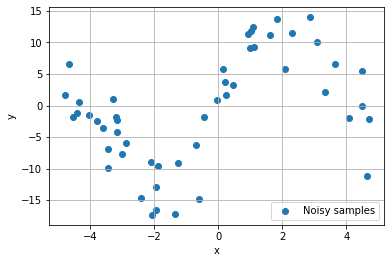

In [5]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

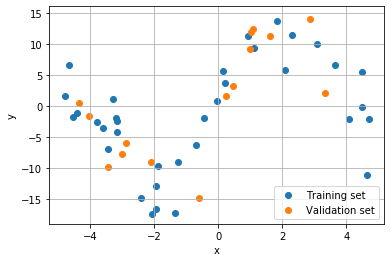

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [7]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [8]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(memory=None,
         steps=[('pol',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('sca',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
                                  normalize=False))],
         verbose=False)

Pipeline(memory=None,
         steps=[('pol',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('sca',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Lasso(alpha=0.1, copy_X=True, fit_intercept=False,
                       max_iter=50000, normalize=False, positive=False,
                       precompute=False, random_state=42, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

Pipeline(memory=None,
         steps=[('pol',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('sca',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.1, copy_X=True, fit_intercept=False,
                       max_iter=50000, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)

### Fit

Let's fit a model and plot the hypothesis it learns:

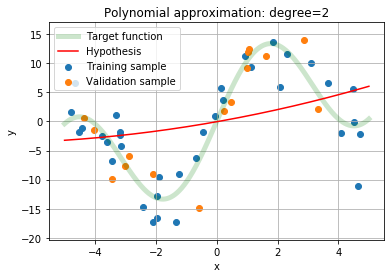

In [9]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

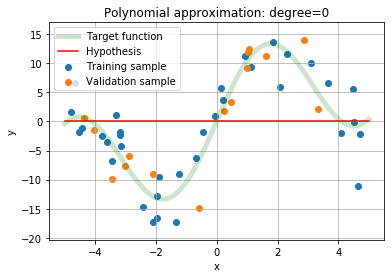

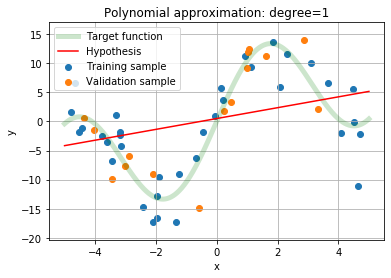

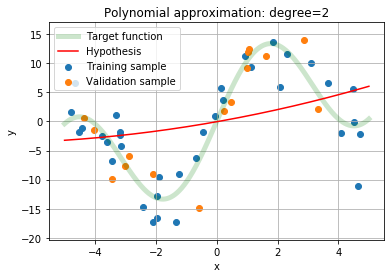

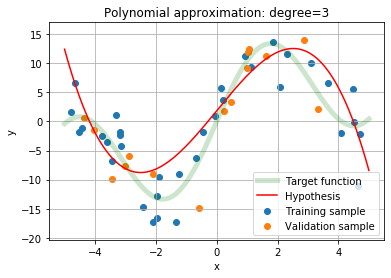

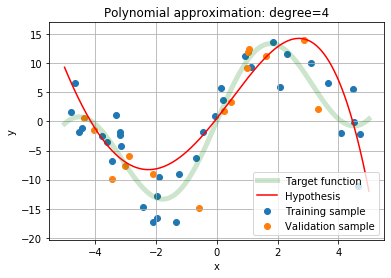

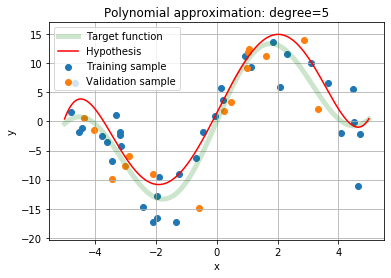

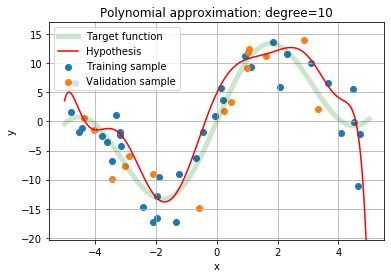

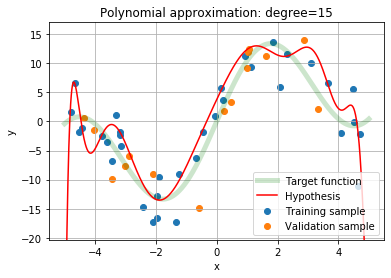

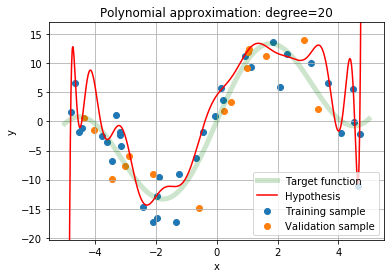

In [10]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

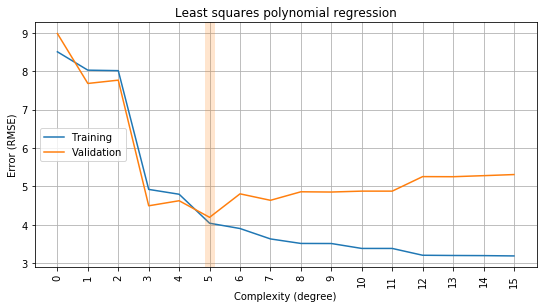

In [11]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [12]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

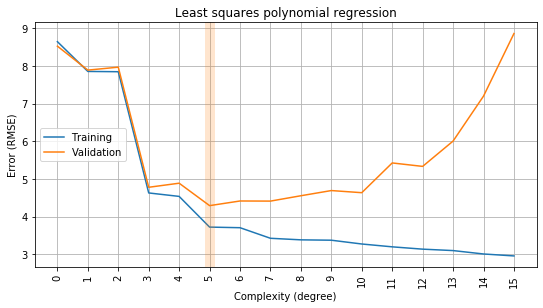

In [13]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [14]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

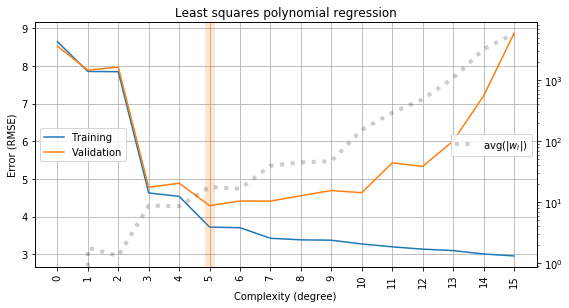

In [15]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

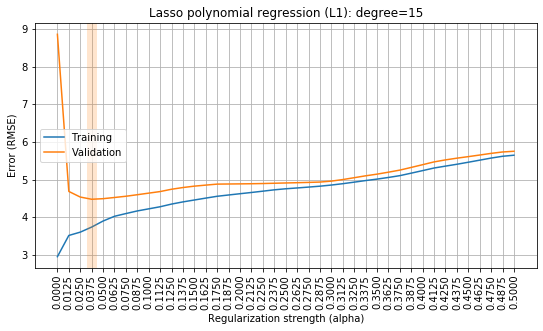

In [16]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

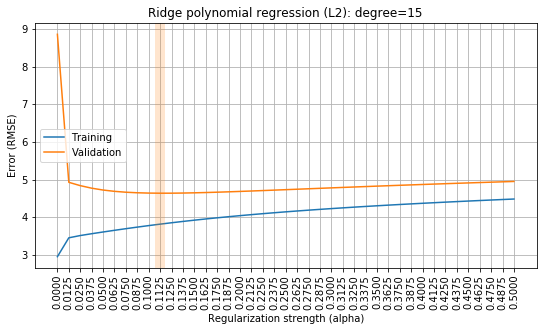

In [17]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [25]:
# Найдем средние по 5 фолдам кросс-валидации коэффы для модели, прогнанной на каждой из альф.

l1_coefs_alpha_path = []
for alpha in ALPHAS:
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    coefs = []
    for split in results['estimator']:
        coefs.append(split['reg'].coef_)
    coefs = np.array(coefs)
    l1_coefs_alpha_path.append(coefs.mean(axis=0))


l1_coefs_alpha_path = np.array(l1_coefs_alpha_path)

In [26]:
# ... и без кросс-валидации.

l1_wocv_coefs_alpha_path = []
for alpha in ALPHAS:
    l1_wocv_coefs_alpha_path.append(make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)['reg'].coef_)
l1_wocv_coefs_alpha_path = np.array(l1_wocv_coefs_alpha_path)

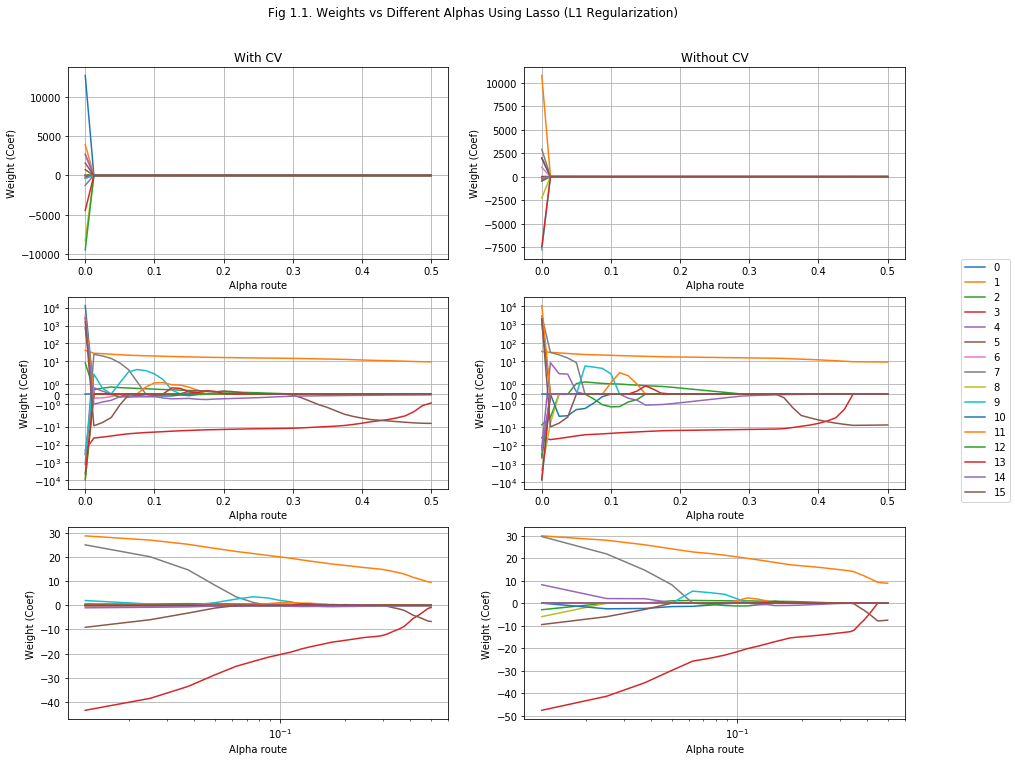

In [27]:
# Построим графики для обоих вариантов (с и без кросс-валидации), показывающие поведение коэффициентов по мере увеличения alpha.
# Сделаем это как для линейного, так и для логарифмического масштаба по обеим осям; включая и не включая первые элементы 
# (которые относятся к модели без регуляризации) - для лучшей визуализации.

fig, axes = plt.subplots(3, 2, figsize=(15,12))
fig.suptitle('Fig 1.1. Weights vs Different Alphas Using Lasso (L1 Regularization)', y=0.95)

for x, weight in enumerate(l1_coefs_alpha_path.T):
    axes[0, 0].plot(ALPHAS, weight, label=x)
    axes[0, 0].set_title('With CV')  
for x, weight in enumerate(l1_wocv_coefs_alpha_path.T):
    axes[0, 1].plot(ALPHAS, weight, label=x)
    axes[0, 1].set_title('Without CV')
for x, weight in enumerate(l1_coefs_alpha_path.T):
    axes[1, 0].plot(ALPHAS, weight, label=x)
    axes[1, 0].set_yscale('symlog')  
for x, weight in enumerate(l1_wocv_coefs_alpha_path.T):
    axes[1, 1].plot(ALPHAS, weight, label=x)
    axes[1, 1].set_yscale('symlog')
for x, weight in enumerate(l1_coefs_alpha_path.T):
    axes[2, 0].semilogx(ALPHAS[1:], weight[1:], label=x)    
for x, weight in enumerate(l1_wocv_coefs_alpha_path.T):
    axes[2, 1].semilogx(ALPHAS[1:], weight[1:], label=x)
handles, labels = axes[1, 1].get_legend_handles_labels()

fig.legend(handles, labels, loc='right')
for row in axes:
    for ax in row:
        ax.set(xlabel='Alpha route', ylabel='Weight (Coef)')
        ax.grid(True);

#### L2

In [28]:
# Выполним то же самое для L2-регуляризации (Ridge-регрессии).

l2_coefs_alpha_path = []
for alpha in ALPHAS:
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    coefs = []
    for split in results['estimator']:
        coefs.append(split['reg'].coef_)
    coefs = np.array(coefs)
    l2_coefs_alpha_path.append(coefs.mean(axis=0))


l2_coefs_alpha_path = np.array(l2_coefs_alpha_path)

In [29]:
l2_wocv_coefs_alpha_path = []
for alpha in ALPHAS:
    l2_wocv_coefs_alpha_path.append(make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)['reg'].coef_)
l2_wocv_coefs_alpha_path = np.array(l2_wocv_coefs_alpha_path)

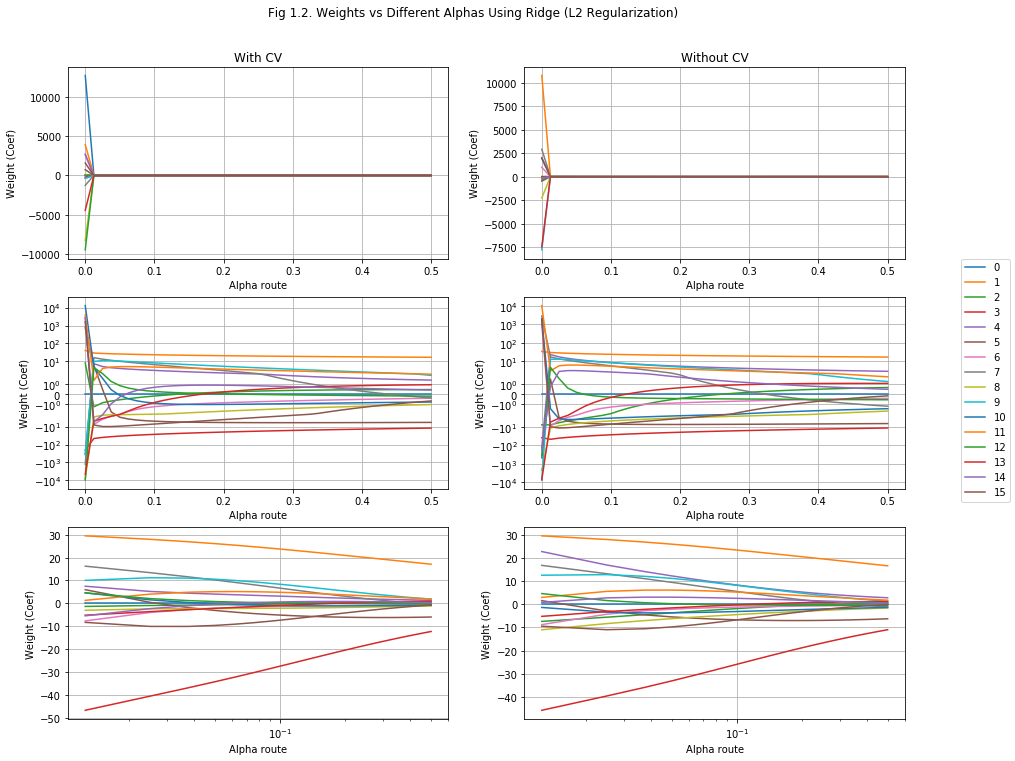

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(15,12))
fig.suptitle('Fig 1.2. Weights vs Different Alphas Using Ridge (L2 Regularization)', y=0.95)

for x, weight in enumerate(l2_coefs_alpha_path.T):
    axes[0, 0].plot(ALPHAS, weight, label=x)
    axes[0, 0].set_title('With CV')  
for x, weight in enumerate(l2_wocv_coefs_alpha_path.T):
    axes[0, 1].plot(ALPHAS, weight, label=x)
    axes[0, 1].set_title('Without CV')
for x, weight in enumerate(l2_coefs_alpha_path.T):
    axes[1, 0].plot(ALPHAS, weight, label=x)
    axes[1, 0].set_yscale('symlog')  
for x, weight in enumerate(l2_wocv_coefs_alpha_path.T):
    axes[1, 1].plot(ALPHAS, weight, label=x)
    axes[1, 1].set_yscale('symlog')
for x, weight in enumerate(l2_coefs_alpha_path.T):
    axes[2, 0].semilogx(ALPHAS[1:], weight[1:], label=x)    
for x, weight in enumerate(l2_wocv_coefs_alpha_path.T):
    axes[2, 1].semilogx(ALPHAS[1:], weight[1:], label=x)
handles, labels = axes[1, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')
for row in axes:
    for ax in row:
        ax.set(xlabel='Alpha route', ylabel='Weight (Coef)')
        ax.grid(True);

#### Summary

Вычислены коэффициенты линейной регрессии, обученной на тренировочном сете для каждой из величин регуляризационного параметра alpha из списка ALPHAS. Вычисления проведены отдельно для Lasso и Ridge регрессий, а также с и без использования 5-folds крос-валидации. Для каждого случая построены графики вида 'Коэффициенты vs Различные значения alpha' на линейной (с включением модели без регуляризации) и логарифмических по y (также с включением 0-рег) и x осям (без включения такой модели) шкалах для возможности взглянуть на поведение коэффициентов под разными углами.  
Из графиков наглядно видно, что, действительно, для обоих способов регуляризации (L1 & L2) коэффициенты в целом имеют тенденцию к снижению с увеличением параметра alpha. Отдельно отметим следующие наблюдения:  
- уже первый шаг с добавлением минимального значения alpha снижает коэффициенты моделей до нескольких порядков, что очень хорошо видно на верхних и средних парах графиков 1.1 и 1.2;
- наличие кросс-валидации ожидаемо не изменяет этого поведения, однако некоторые различия в поведении коэффициентов присутствуют. Так, несколько отличается поведение коэффициентов 3 и 5 на финальных значениях alpha в Lasso;
- коэффициент №5 при более высоких alpha из списка наоборот, начинает несколько увеличиваться - на графиках Lasso это особенно хорошо видно.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [36]:
# Приведем набор коэффициентов при разных значениях alpha в вид Дата-фрейма, добавив столбцы, отражающие количество 
# нулевых и ненулевых коэффициентов.

l1_alphas_coefs_df = pd.DataFrame(l1_coefs_alpha_path, index=ALPHAS, 
                                  columns=[f'w_{w}' for w in range(len(l1_coefs_alpha_path[0]))])
w_n = l1_alphas_coefs_df.columns
l1_alphas_coefs_df['num_NONzero_coefs'] = l1_alphas_coefs_df[w_n][l1_alphas_coefs_df != 0].count(axis=1)
l1_alphas_coefs_df['num_zero_coefs'] = l1_alphas_coefs_df[w_n][l1_alphas_coefs_df == 0].count(axis=1)

In [37]:
# Изменим порядок столбцов для удобства презентации.

novus_ordo = l1_alphas_coefs_df.columns.tolist()[-2:] + l1_alphas_coefs_df.columns.tolist()[:-2]
l1_alphas_coefs_df = l1_alphas_coefs_df[novus_ordo]
l1_alphas_coefs_df

,num_NONzero_coefs,num_zero_coefs,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15
0.0000,15,1,0.0,40.993316,8.294028,-199.327724,-331.102612,738.180635,2597.485587,-1262.498212,-8289.899532,-376.294618,12779.205700,3937.746944,-9495.984009,-4459.256884,2733.132403,1585.480096
0.0125,9,7,0.0,28.840109,0.428966,-43.538549,0.628747,0.000000,-0.409635,25.106773,0.000000,1.990993,0.000000,0.000000,0.000000,0.000000,-1.016782,-9.105437
0.0250,9,7,0.0,27.078698,0.584729,-38.581447,0.285368,0.000000,-0.388065,20.162863,0.000000,0.561569,0.000000,0.000000,0.000000,0.000000,-0.800371,-5.957517
0.0375,10,6,0.0,25.324386,0.700914,-33.616367,0.001363,0.000000,-0.262504,14.699659,-0.081327,0.000000,0.000000,0.000000,-0.001178,0.000000,-0.634701,-3.185489
0.0500,11,5,0.0,23.635303,0.637224,-28.774559,0.000000,0.000000,-0.037697,8.291724,-0.246238,1.116673,-0.024375,0.000000,-0.311496,0.000000,-0.274155,-1.096614
0.0625,9,7,0.0,22.359730,0.601035,-25.284687,0.000000,0.000000,0.000000,3.514833,-0.263770,2.615593,-0.297147,0.000000,0.000000,0.000000,-0.285026,-0.100311
0.0750,9,7,0.0,21.498759,0.561485,-23.267756,0.000000,0.000000,0.000000,1.225810,-0.249524,3.561968,-0.139114,0.000000,-0.142740,0.000000,-0.276116,0.000000
0.0875,10,6,0.0,20.727671,0.525817,-21.567697,0.000000,0.000000,-0.003082,0.000000,-0.238934,3.080435,-0.015614,0.697646,-0.247709,0.000000,-0.267861,0.000000
0.1000,10,6,0.0,20.107391,0.487097,-20.398442,0.000000,0.000000,-0.006410,0.000000,-0.078975,2.036737,-0.137273,1.113931,-0.262190,0.000000,-0.253393,0.000000
0.1125,10,6,0.0,19.526687,0.450518,-19.352018,0.000000,0.000000,-0.004733,0.000000,-0.003671,1.457019,-0.203373,1.148534,-0.097251,0.000000,-0.401237,0.000000


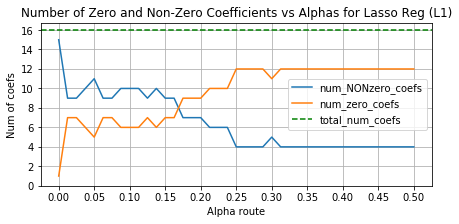

In [38]:
# Отобразим количество (не-)нулевых коэффициентов на графике.

plt.figure(figsize=(7,3))
for z in ['num_NONzero_coefs', 'num_zero_coefs']:
    plt.plot(ALPHAS, l1_alphas_coefs_df[z], label=z)
plt.axhline(y=len(w_n), label='total_num_coefs', ls='--', color='green')
plt.xticks(ALPHAS[::4])
plt.yticks(range(0, len(w_n) + 1, 2))
plt.xlabel('Alpha route')
plt.ylabel('Num of coefs')
plt.title('Number of Zero and Non-Zero Coefficients vs Alphas for Lasso Reg (L1)')
plt.grid(True)
plt.legend();

#### L2

In [39]:
# Проведем те же операции для Ridge.

l2_alphas_coefs_df = pd.DataFrame(l2_coefs_alpha_path, index=ALPHAS, 
                                  columns=[f'w_{w}' for w in range(len(l2_coefs_alpha_path[0]))])
w_n = l2_alphas_coefs_df.columns
l2_alphas_coefs_df['num_NONzero_coefs'] = l2_alphas_coefs_df[w_n][l2_alphas_coefs_df != 0].count(axis=1)
l2_alphas_coefs_df['num_zero_coefs'] = l2_alphas_coefs_df[w_n][l2_alphas_coefs_df == 0].count(axis=1)

In [40]:
l2_alphas_coefs_df = l2_alphas_coefs_df[novus_ordo]
l2_alphas_coefs_df

,num_NONzero_coefs,num_zero_coefs,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15
0.0000,15,1,0.0,40.993316,8.294028,-199.327724,-331.102612,738.180635,2597.485587,-1262.498212,-8289.899532,-376.294618,12779.205700,3937.746944,-9495.984009,-4459.256884,2733.132403,1585.480096
0.0125,15,1,0.0,29.418257,-1.282098,-46.467914,7.512246,5.994204,-7.575867,16.230450,-2.945252,10.053670,4.605818,1.355950,4.625363,-5.100474,-5.378021,-8.215585
0.0250,15,1,0.0,27.906882,-0.876043,-40.304757,5.230989,0.473271,-3.897708,13.402855,-2.332695,11.203862,1.570682,4.072389,2.117969,-3.533826,-2.236292,-9.982394
0.0375,15,1,0.0,26.863814,-0.704703,-36.681081,4.486555,-1.796118,-2.671295,11.588223,-2.223052,11.027205,0.433777,4.893625,1.257181,-2.692197,-0.981507,-9.987017
0.0500,15,1,0.0,26.029291,-0.577266,-34.027778,4.076637,-3.041783,-2.081608,10.215454,-2.185275,10.539561,-0.145655,5.151374,0.835985,-2.124172,-0.306507,-9.545159
0.0625,15,1,0.0,25.322956,-0.467142,-31.905161,3.785819,-3.828722,-1.743943,9.102255,-2.156545,9.974753,-0.481411,5.185165,0.592996,-1.698331,0.103947,-8.974951
0.0750,15,1,0.0,24.707427,-0.368778,-30.128081,3.552830,-4.368591,-1.528524,8.166034,-2.125212,9.407297,-0.689585,5.117446,0.438198,-1.360356,0.370093,-8.381568
0.0875,15,1,0.0,24.161187,-0.280442,-28.599129,3.354921,-4.759225,-1.380108,7.360883,-2.089890,8.863872,-0.823629,5.001305,0.332552,-1.082636,0.548944,-7.804661
0.1000,15,1,0.0,23.670205,-0.201167,-27.259410,3.181753,-5.052361,-1.271570,6.657825,-2.051372,8.353696,-0.911577,4.862453,0.256566,-0.849106,0.671280,-7.259416
0.1125,15,1,0.0,23.224589,-0.130134,-26.069865,3.027744,-5.278061,-1.188232,6.036982,-2.010744,7.878914,-0.969466,4.714228,0.199533,-0.649507,0.755227,-6.750819


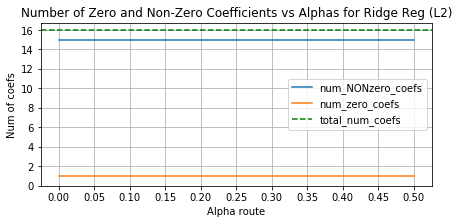

In [41]:
plt.figure(figsize=(7,3))
for z in ['num_NONzero_coefs', 'num_zero_coefs']:
    plt.plot(ALPHAS, l2_alphas_coefs_df[z], label=z)
plt.axhline(y=len(w_n), label='total_num_coefs', ls='--', color='green')
plt.xticks(ALPHAS[::4])
plt.yticks(range(0, len(w_n) + 1, 2))
plt.xlabel('Alpha route')
plt.ylabel('Num of coefs')
plt.title('Number of Zero and Non-Zero Coefficients vs Alphas for Ridge Reg (L2)')
plt.grid(True)
plt.legend();

#### Summary

Сформированы таблицы в виде Дата-фреймов для обоих способов регуляризации (L1 & L2), содержащие величины коэффициентов (весов) обеих регрессий для соответствующих величин alpha из списка ALPHAS. Из них видно следующее:  
- действительно, Lasso регрессия зануляет ряд коэффициентов;
- количество (не-)нулевых коэффициентов изменяется до некоторого значения alpha, после которого становится постоянным;
- в то же время набор коэффициентов Ridge регрессии всегда полный - нулевые коэффициенты отсутствуют (кроме самого первого) вне зависимости от величины alpha;
- в обеих регрессиях есть постоянный нулевой коэффициент в начале списка весов - это коэффициент, присваиваемый первому параметру в X, т.к. она везде константа и равен единице.  

Для визуализации вышеописанного построены графики зависимости количества (не-)нулевых коэффициентов от параметра alpha для каждой из регрессий (Lasso & Ridge).

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

1. При использовании в регуляризованной модели параметров, не приведенных в один масштаб, получается, соответственно, очень большой разброс в коэффициентах. Большие коэффициенты, являясь частью регуляризационного параметра, сильно его увеличивают, а серьезная разница в их масштабе приводит к тому, что регуляризация штрафует их гораздо сильнее других. Особенно эта разница характерна для L2 регуляризации, т.к. ее рег. параметр вычисляется по евклидовому расстоянию, т.е. через квадраты весов. Больше штрафуя одни фичи (коэффициенты), основываясь больше на их масштабе, чем на реальной значимости для предсказания, модель ухудшает свою точность.   
![title](cost_func.PNG)
2. От прибавки рег. параметра, в состав коготорого входят большие коэффициенты сильно растет значение функции потерь. Чтобы снизить эту прибавку, регуляризационный параметр alpha (lambda) должен быть очень маленьким, близким к нулю. А близкий к нулю параметр alpha при больших коэффициентах - прямой путь к переобучению. Т.е. при больших весах мы не можем найти хорошего решения (баланса между недо- и переобученностью) - мы либо увеличиваем функцию потерь (недообучая модель при увеличении alpha), либо увеличиваем переобученность (снижая функцию потерь при стремлении alpha к нулю).  
3. Если же мы приводим все параметры в один масштаб, эта проблема решается, т.к. модель не задирает отдельные коэффициенты и позволяет эффективно применять регуляризацию.  
4. Помимо этого, модель на приведенных в один масштаб данных обучается гораздо быстрее. Механизм поиска оптимальных весов линейной регрессии основан на градиентном спуске, каждый шаг которого для каждой фичи и ее веса считается по формуле:
![title](grad_decent.PNG) 
где xj как раз и есть вектор значений той или иной фичи. Соответственно, чем больше его значения, тем большие шаги делает градиентный спуск на пути к точке минимума. Такой спуск занимает гораздо больше времени, чем на фичах одного масштаба. К тому же, он может несколько "промахнуться" мимо точки минимума. 